In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from psfutil_1d import *

In [2]:
BAND = "H158"

psf_in = psf_single_slit(LDP[BAND])
psf_in_t = np.fft.rfft(np.fft.ifftshift(psf_in))
psf_inp = pixelate_psf(psf_in)
psf_inp_t = np.fft.rfft(np.fft.ifftshift(psf_inp))

# Let's try a wider target output PSF, and thus a wider weight field.
psf_out = psf_gaussian(SIGMA[BAND] * 2)
psf_out_t = np.fft.rfft(np.fft.ifftshift(psf_out))
weight_t = psf_out_t / psf_inp_t  # 9/7/2025
# weight_t[NPIX::NPIX] = 0  # Fix division by zero modes.
weight_t[NPIX::] = 0; weight_t.imag = 0
weight = np.fft.ifftshift(np.fft.irfft(weight_t, n=NTOT))

/tmp/ipykernel_22649/3200962280.py:11: RuntimeWarning: invalid value encountered in divide
  weight_t = psf_out_t / psf_inp_t  # 9/7/2025


/home/kailicao/fast_imcom_dev/psfutil_1d.py:116: RuntimeWarning: invalid value encountered in log10
  axs[1].plot(x, np.log10(psf))


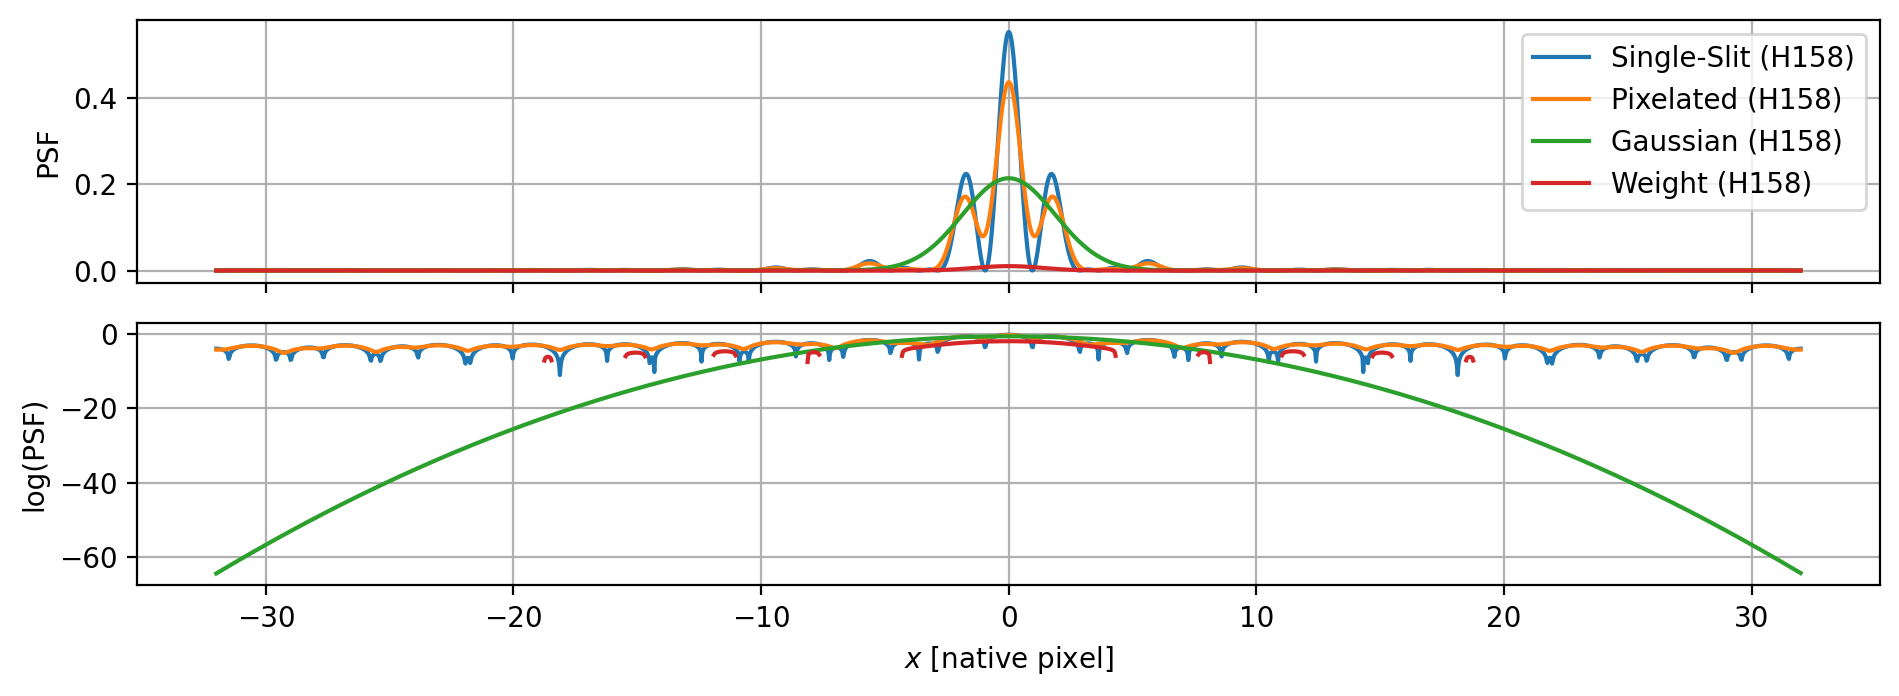

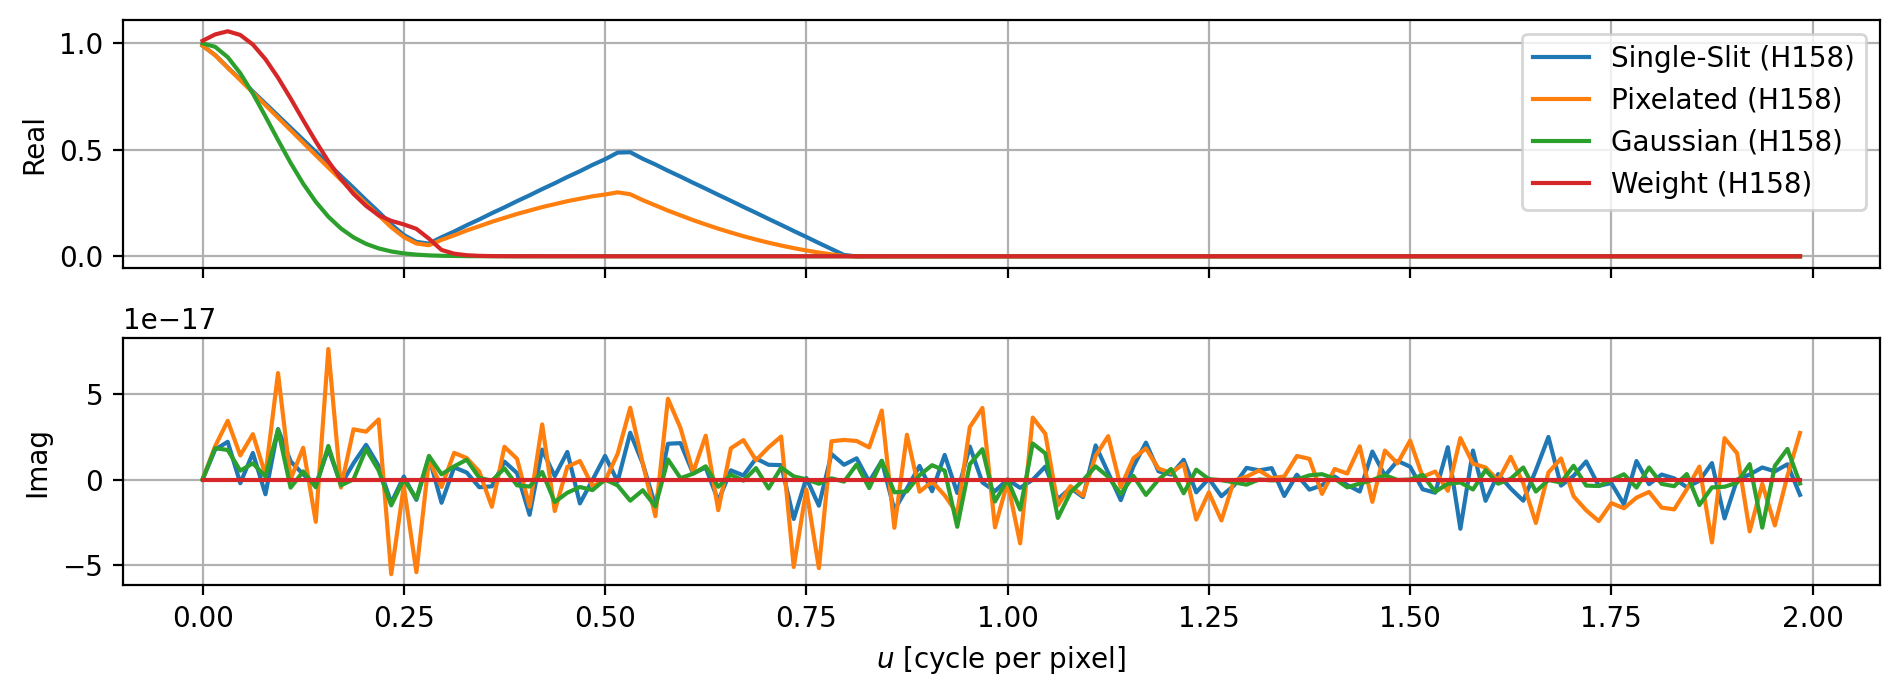

In [3]:
Sep4_plots = True

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for func, label in zip([psf_in, psf_inp, psf_out, weight],
                           ["Single-Slit", "Pixelated", "Gaussian", "Weight"]):
        visualize_psf(axs, func, f"{label} ({BAND})")

    format_and_show(fig, axs)

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for i, part in enumerate(["real", "imag"]):
        for func, label in zip([psf_in_t/SAMP, psf_inp_t/SAMP, psf_out_t/SAMP, weight_t],
                               ["Single-Slit", "Pixelated", "Gaussian", "Weight"]):
            # if label not in ["Pixelated", "Weight"]: continue
            axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:NPIX*2],
                        getattr(func, part)[:NPIX*2], label=f"{label} ({BAND})")
        axs[i].set_ylabel(part.capitalize())

    axs[1].set_xlabel('$u$ [cycle per pixel]')
    format_and_show(fig, axs)

/home/kailicao/fast_imcom_dev/psfutil_1d.py:116: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(x, np.log10(psf))


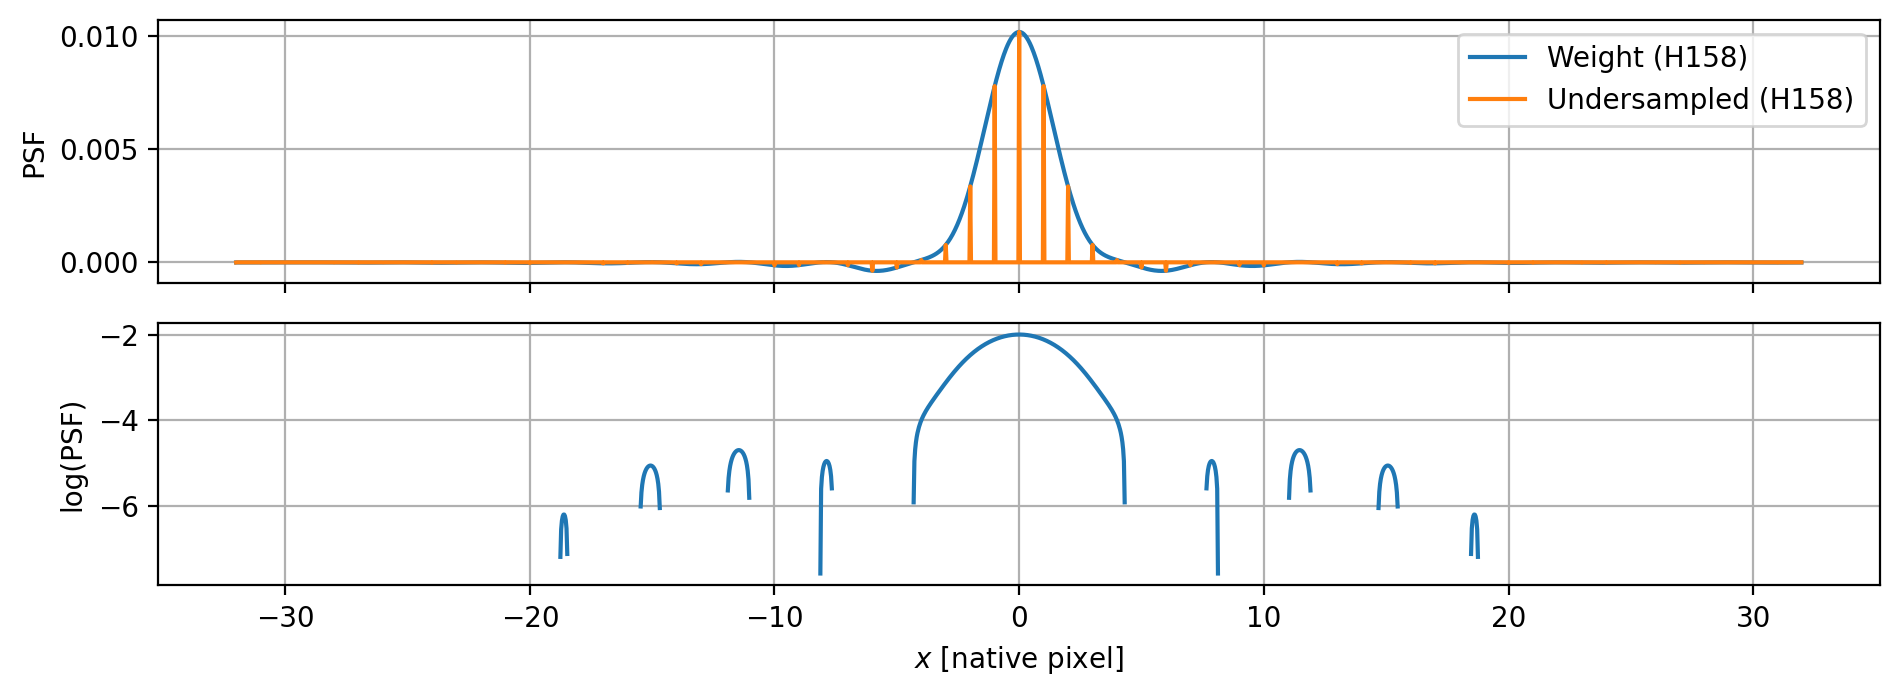

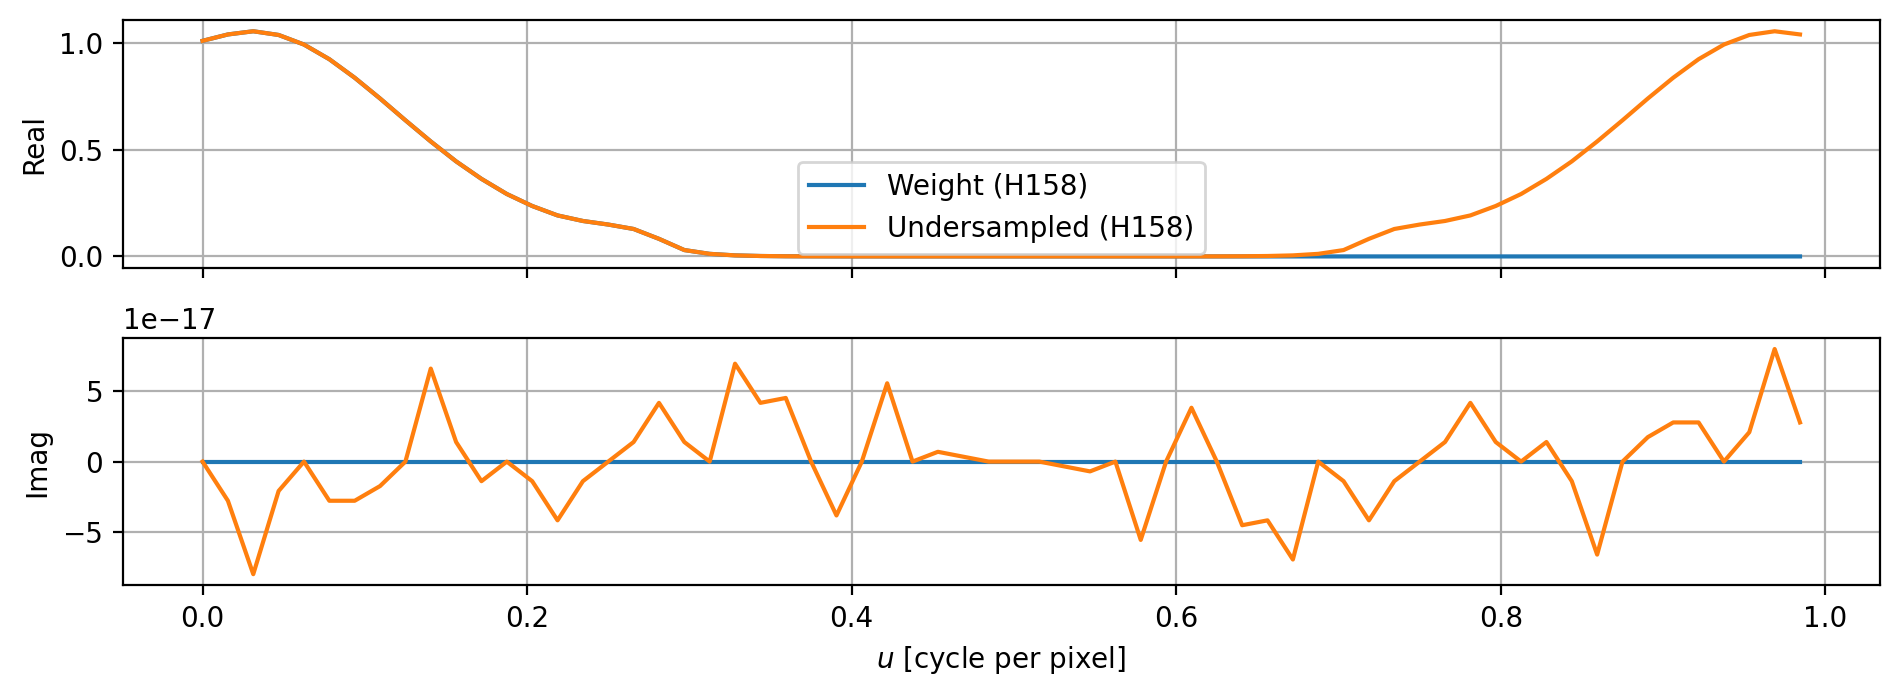

In [4]:
# We have to undersample the weight field, so...
weightu = np.zeros_like(weight)
weightu[::SAMP] = weight[::SAMP] * SAMP
weightu_t = np.fft.rfft(np.fft.ifftshift(weightu))

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for func, label in zip([weight, weightu/SAMP],
                           ["Weight", "Undersampled"]):
        visualize_psf(axs, func, f"{label} ({BAND})")

    format_and_show(fig, axs)

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for i, part in enumerate(["real", "imag"]):
        for func, label in zip([weight_t, weightu_t],
                               ["Weight", "Undersampled"]):
            axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:2*SAMP],
                        getattr(func, part)[:2*SAMP], label=f"{label} ({BAND})")
        axs[i].set_ylabel(part.capitalize())

    axs[1].set_xlabel('$u$ [cycle per pixel]')
    format_and_show(fig, axs)

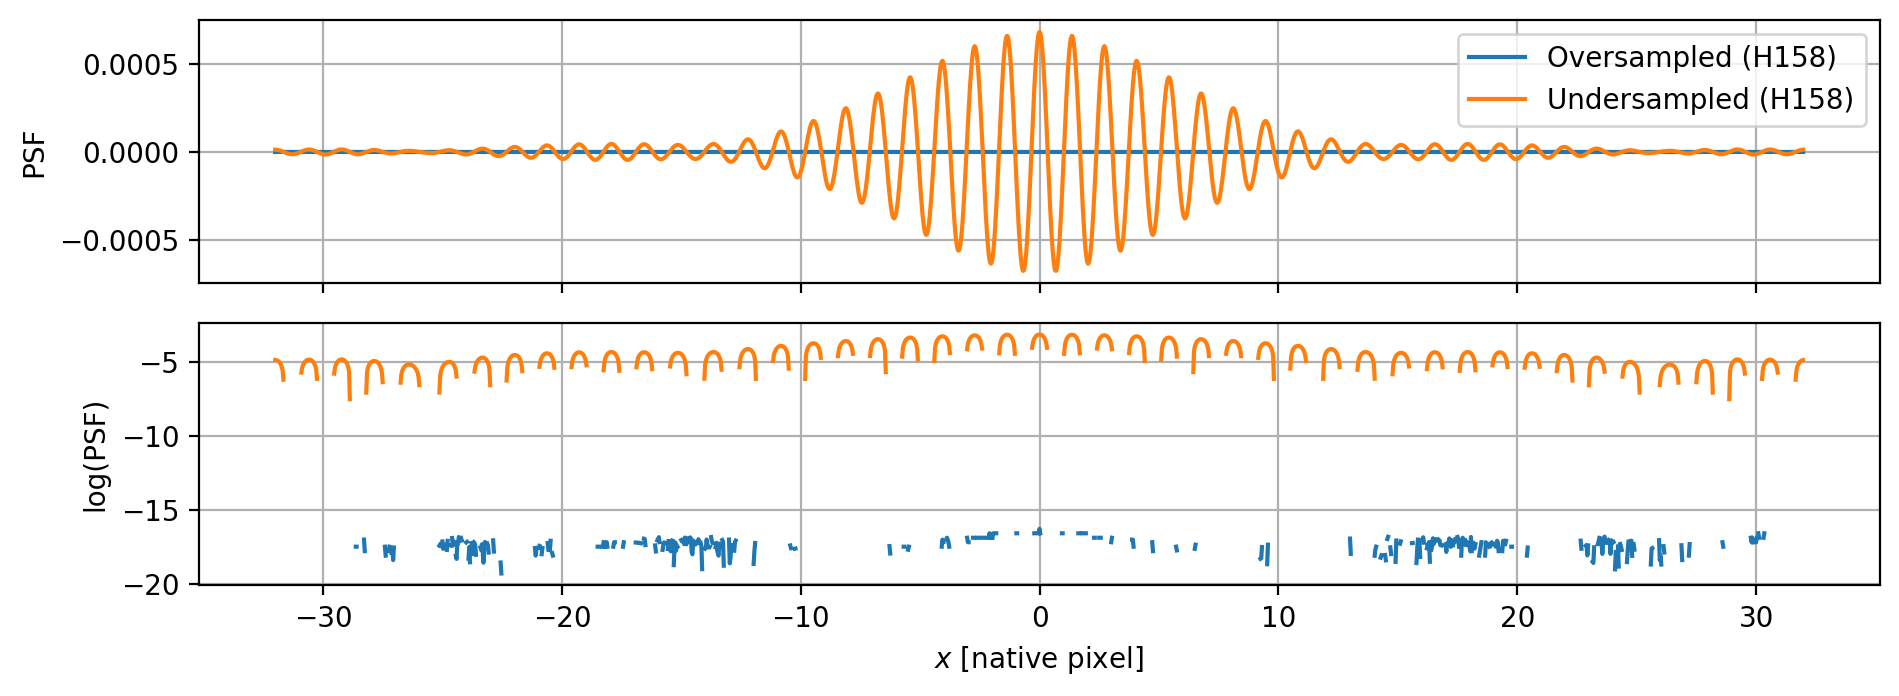

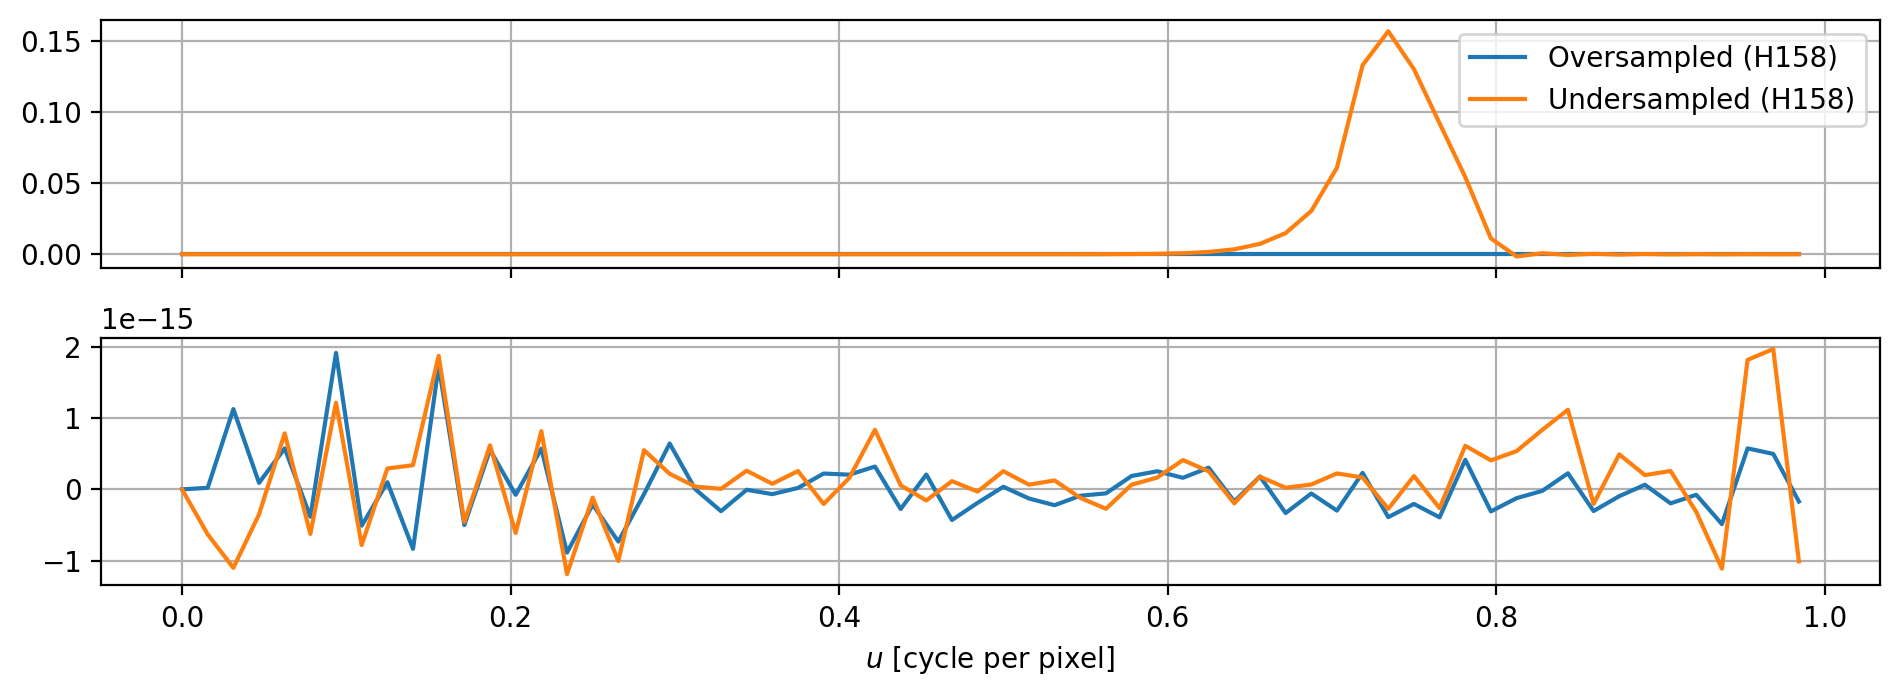

In [5]:
# Let's compute the as-realized output PSFs, oversampled and undersampled.
psf_outo = np.fft.ifftshift(np.fft.irfft(weight_t * psf_inp_t, n=NTOT))
psf_outu = np.fft.ifftshift(np.fft.irfft(weightu_t * psf_inp_t, n=NTOT))

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for func, label in zip([psf_outo-psf_out, psf_outu-psf_out],
                           ["Oversampled", "Undersampled"]):
        visualize_psf(axs, func, f"{label} ({BAND})")

    format_and_show(fig, axs)

if Sep4_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for i, part in enumerate(["real", "imag"]):
        for func, label in zip([np.fft.rfft(np.fft.ifftshift(psf_outo-psf_out)),
                                np.fft.rfft(np.fft.ifftshift(psf_outu-psf_out))],
                               ["Oversampled", "Undersampled"]):
            axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:2*SAMP],
                        getattr(func, part)[:2*SAMP], label=f"{label} ({BAND})")

    axs[1].set_xlabel('$u$ [cycle per pixel]')
    format_and_show(fig, axs)

In [6]:
# How does the target PSF width affect the PSF leakage?
coefarr = np.linspace(1.0, 4.0, 121)
leakage = np.zeros((5, 121))

for j, (band, sigma) in enumerate(SIGMA.items()):
    for i, coef in enumerate(coefarr):
        my_psf_out = psf_gaussian(coef * sigma)
        my_psf_out_t = np.fft.rfft(np.fft.ifftshift(my_psf_out))
        my_weight_t = my_psf_out_t / psf_inp_t  # 9/7/2025
        # my_weight_t[NPIX::NPIX] = 0  # Fix division by zero modes.
        my_weight_t[NPIX::] = 0; my_weight_t.imag = 0
        my_weight = np.fft.ifftshift(np.fft.irfft(my_weight_t, n=NTOT))

        my_weightu = np.zeros_like(my_weight)
        my_weightu[::SAMP] = my_weight[::SAMP] * SAMP
        my_weightu_t = np.fft.rfft(np.fft.ifftshift(my_weightu))
        my_psf_outu = np.fft.ifftshift(np.fft.irfft(my_weightu_t * psf_inp_t, n=NTOT))

        leakage[j, i] = square_norm(my_psf_outu-my_psf_out) / square_norm(my_psf_out)

/tmp/ipykernel_22649/153397659.py:9: RuntimeWarning: divide by zero encountered in divide
  my_weight_t = my_psf_out_t / psf_inp_t  # 9/7/2025
/tmp/ipykernel_22649/153397659.py:9: RuntimeWarning: invalid value encountered in divide
  my_weight_t = my_psf_out_t / psf_inp_t  # 9/7/2025


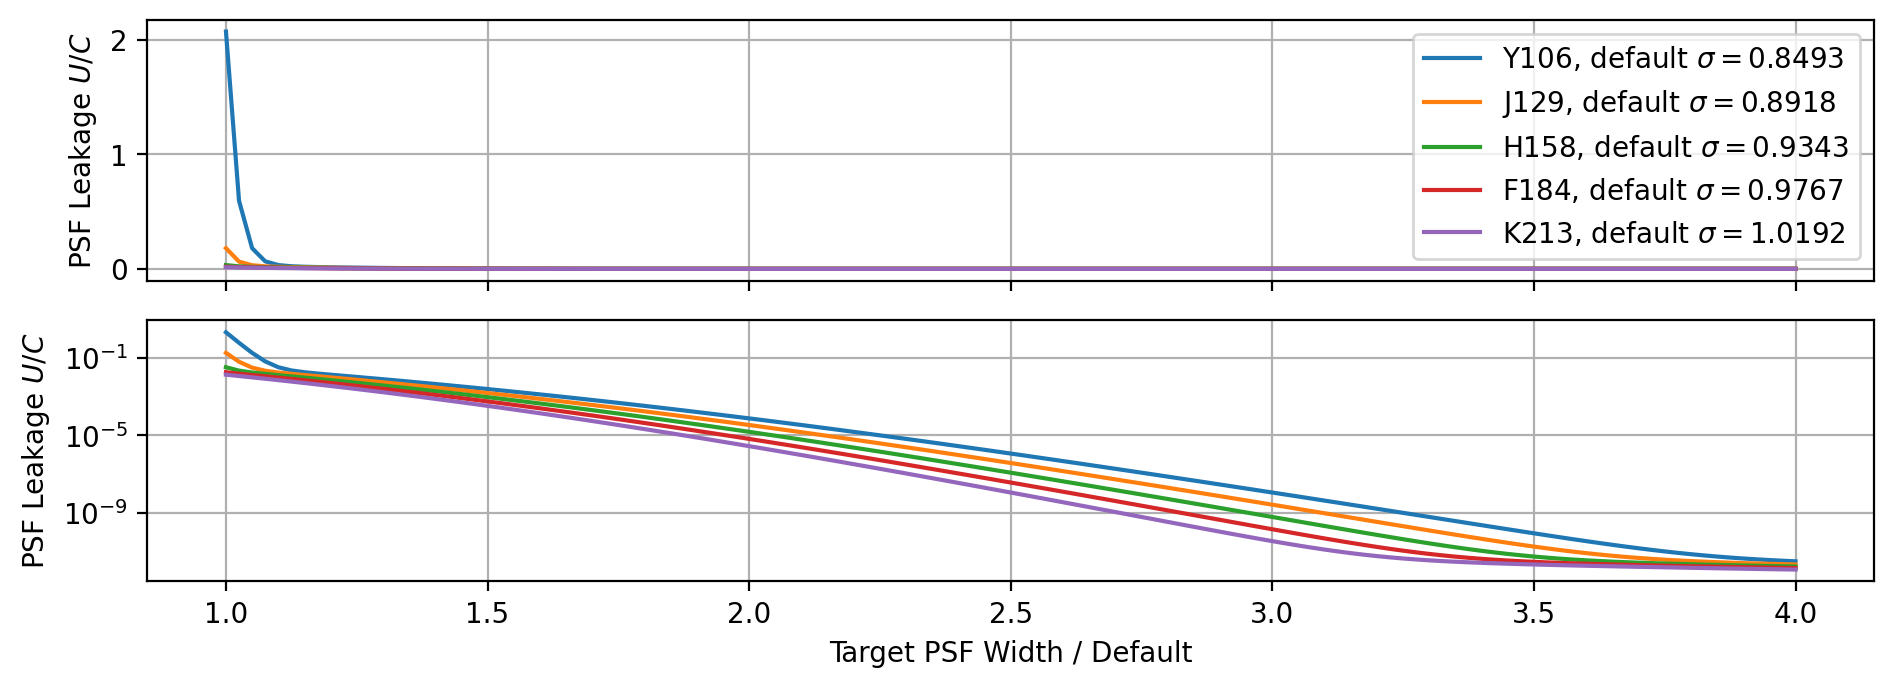

In [7]:
Sep5_plots = True

if Sep5_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for j, (band, sigma) in enumerate(SIGMA.items()):
        for ax in axs:
            ax.plot(coefarr, leakage[j], label=f"{band}, default $\\sigma = {sigma:.4f}$")
            ax.set_ylabel("PSF Leakage $U/C$")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Target PSF Width / Default")

    format_and_show(fig, axs)

In [8]:
# How does the sub-pixel phase affect the as-realized PSF?
psf_outu_arr = np.zeros((SAMP, NTOT))

for shift in range(SAMP):
    my_weightu = np.zeros_like(weight)
    my_weightu[shift::SAMP] = weight[shift::SAMP] * SAMP
    my_weightu_t = np.fft.rfft(np.fft.ifftshift(my_weightu))
    psf_outu_arr[shift] = np.fft.ifftshift(np.fft.irfft(my_weightu_t * psf_inp_t, n=NTOT))

psf_outu_t_arr = np.fft.rfft(np.fft.ifftshift(psf_outu_arr-psf_out, axes=1), axis=1)

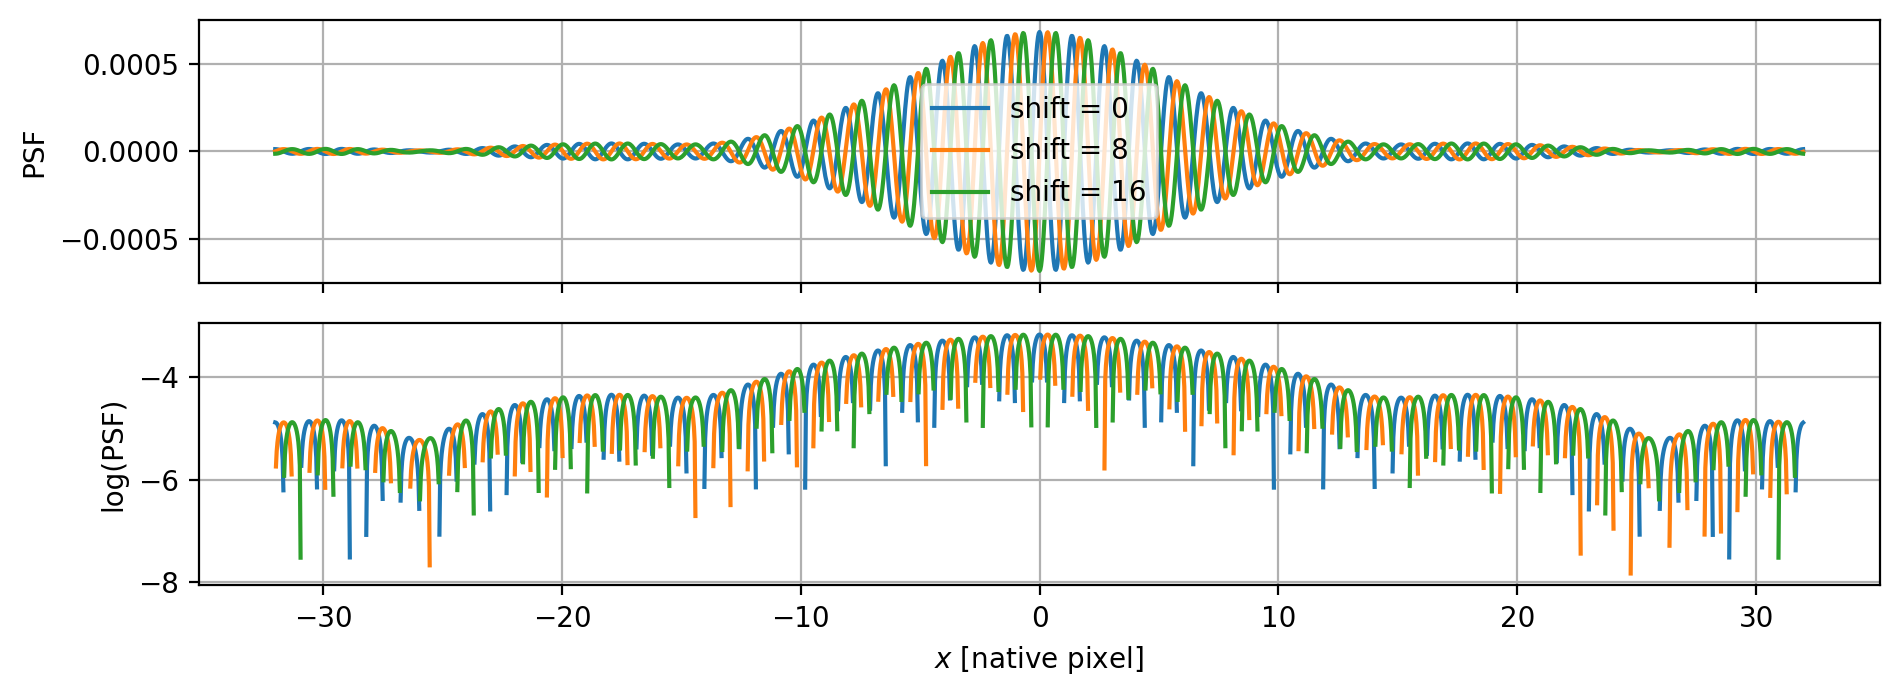

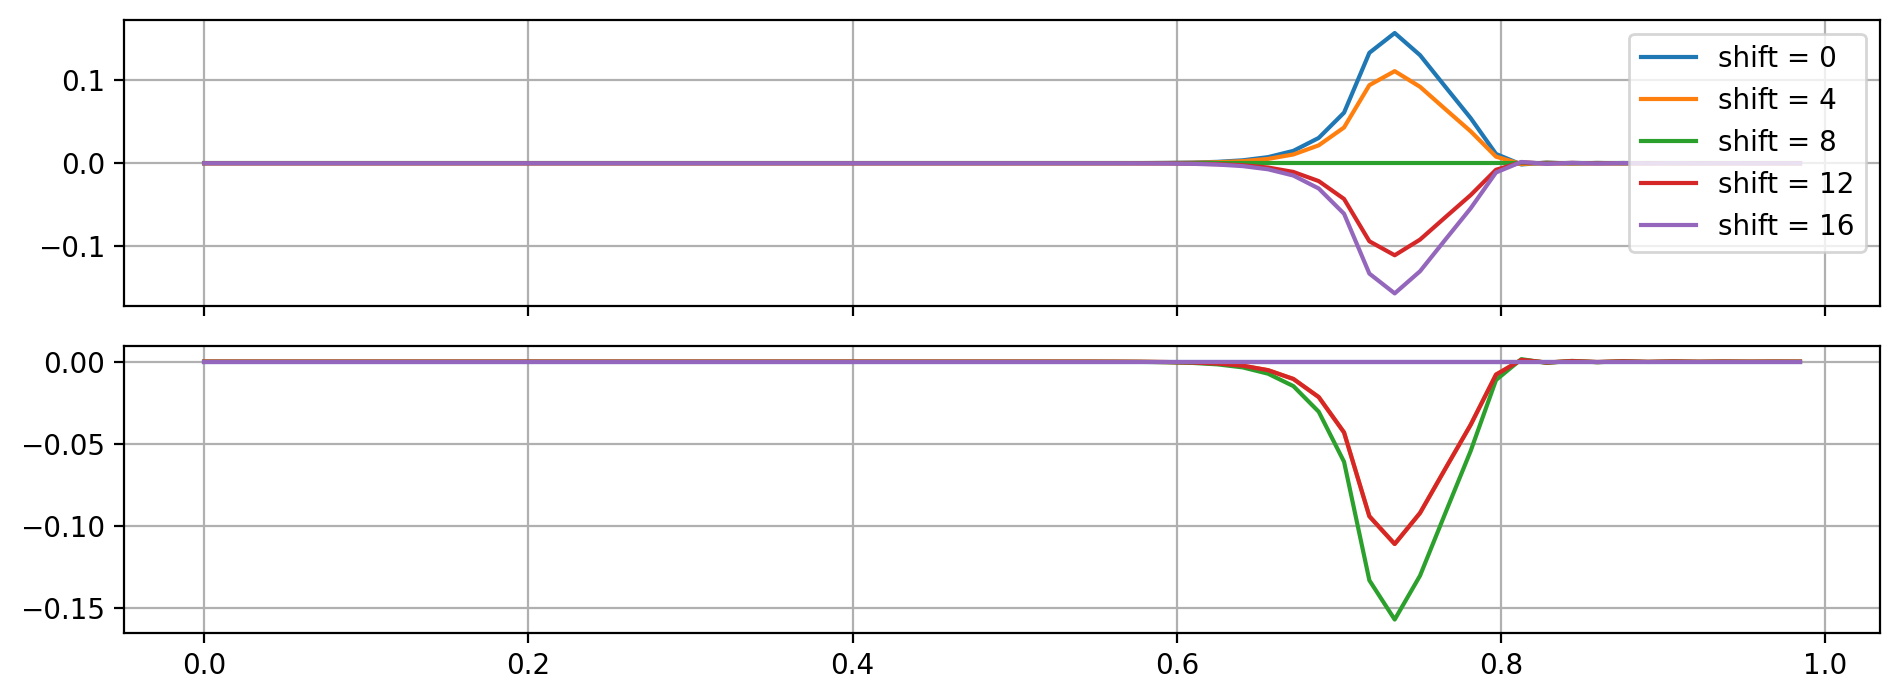

In [9]:
if Sep5_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for shift in [0, 8, 16]:
        visualize_psf(axs, psf_outu_arr[shift]-psf_out, f"{shift = :d}")

    format_and_show(fig, axs)

if Sep5_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for i, part in enumerate(["real", "imag"]):
        for shift in [0, 4, 8, 12, 16]:
            axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:2*SAMP],
                        getattr(psf_outu_t_arr[shift], part)[:2*SAMP], label=f"{shift = :d}")

    format_and_show(fig, axs)

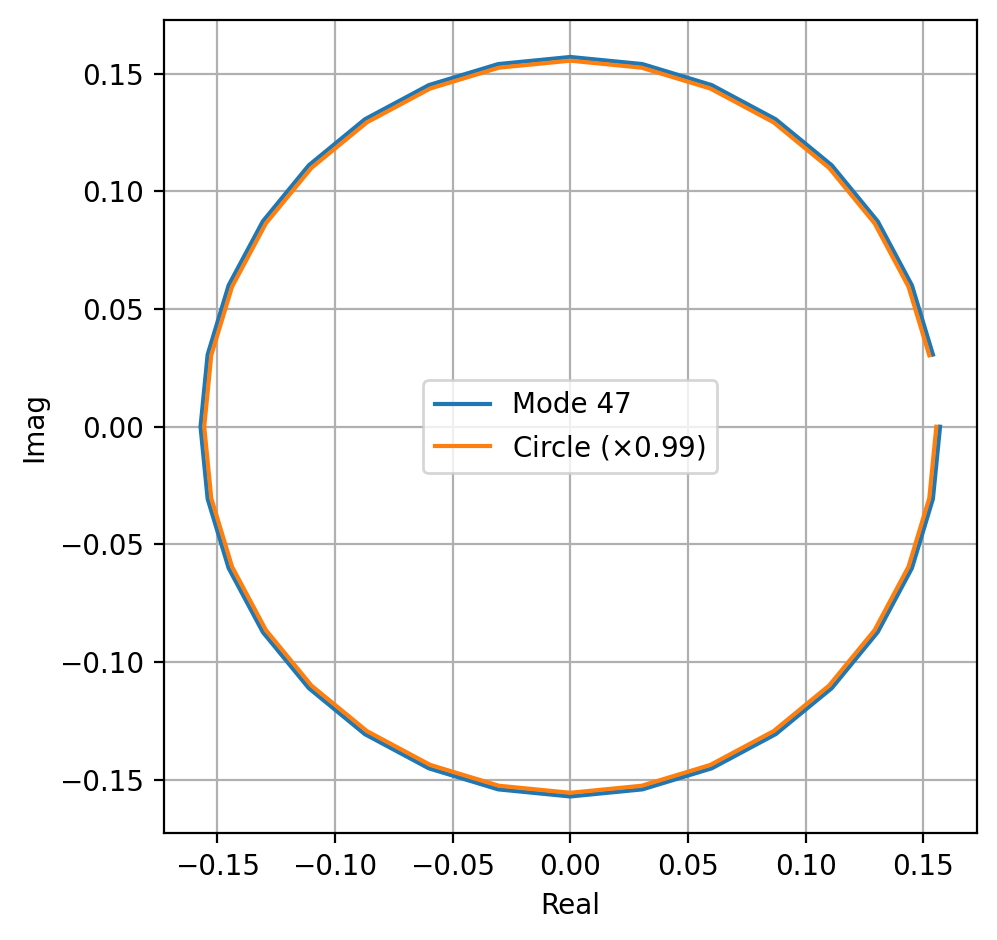

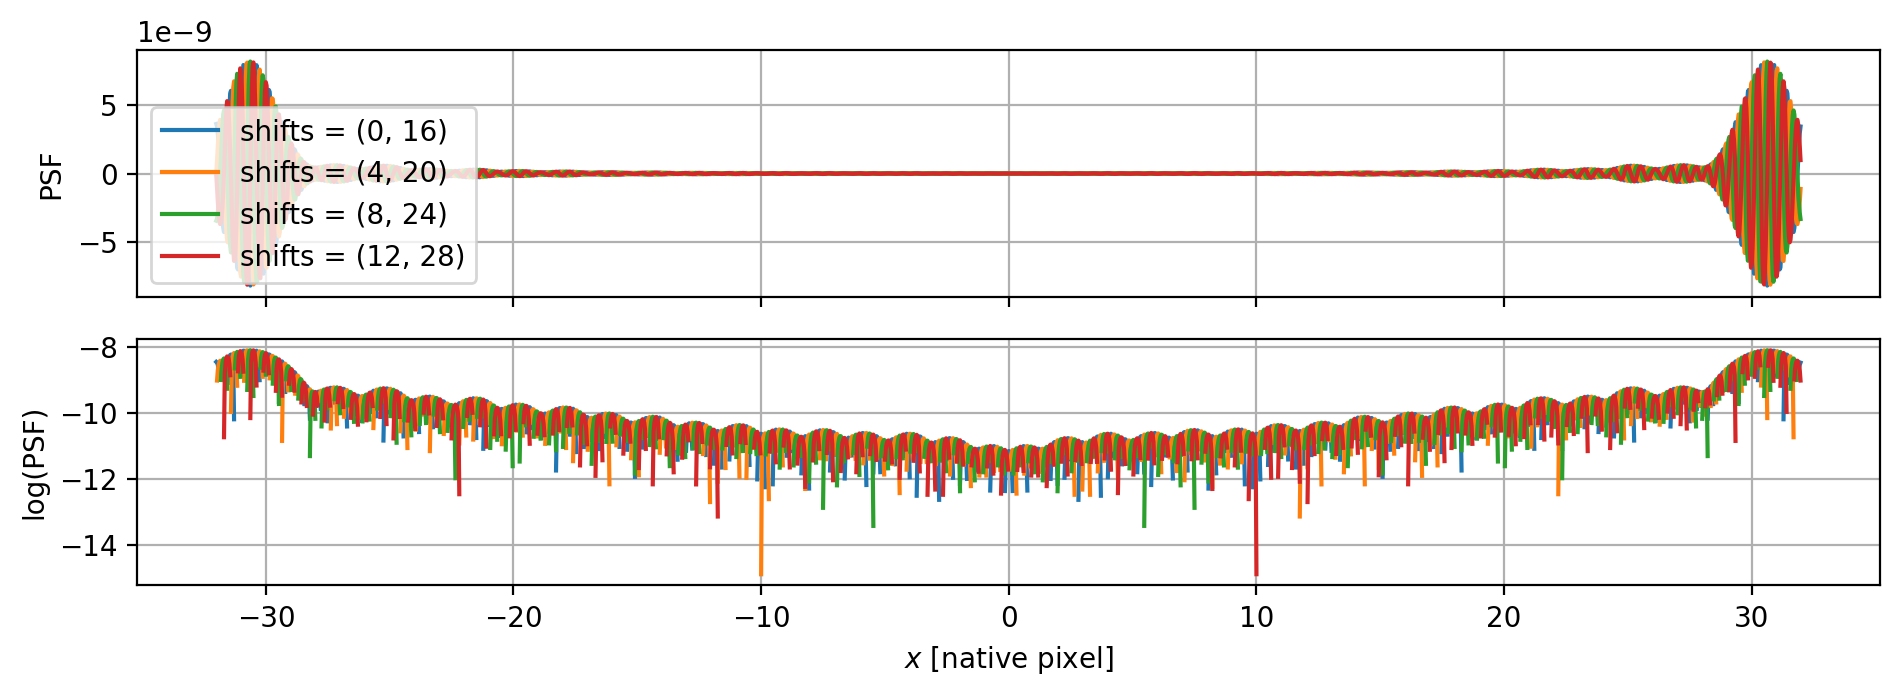

In [10]:
if Sep5_plots:
    fig, ax = plt.subplots(1, 1)

    ax.plot(psf_outu_t_arr[:, 47].real,
            psf_outu_t_arr[:, 47].imag, label="Mode 47")
    radius = np.abs(psf_outu_t_arr[0, 47]) * 0.99
    angles = -np.linspace(0, 2*np.pi, 32, endpoint=False)
    ax.plot(radius * np.cos(angles),
            radius * np.sin(angles), label=r"Circle ($\times0.99$)")

    ax.set_aspect("equal")
    ax.legend()
    ax.set_xlabel("Real")
    ax.set_ylabel("Imag")

    ax.grid()
    fig.tight_layout()
    plt.show()

if Sep5_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for i in [0, 4, 8, 12]:
        psf_ideal = np.fft.ifftshift(np.fft.irfft(
            (psf_outu_t_arr[i] + psf_outu_t_arr[i + SAMP//2]) / 2, n=NTOT))
        visualize_psf(axs, psf_ideal, f"shifts = ({i}, {i + SAMP//2})")

    format_and_show(fig, axs)